In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv("emotion_data.csv", encoding="latin1")

In [4]:
print("🔍 Null values per column:\n", df.isnull().sum())
print("\nTotal null values:", df.isnull().sum().sum())

# 2. Check class distribution (balance of Emotion column)
if "Emotion" in df.columns:
    print("\n📊 Emotion distribution:\n", df['Emotion'].value_counts())
    print("\n🔢 Class percentages:\n", df['Emotion'].value_counts(normalize=True) * 100)
else:
    print("⚠️ No 'Emotion' column found in dataset")

🔍 Null values per column:
 Neutral     0
Joy        38
Sad        26
Angry      26
Fear       72
dtype: int64

Total null values: 162
⚠️ No 'Emotion' column found in dataset


In [5]:
print(df.head(10))

                             Neutral  \
0           finished morning lecture   
1                going library study   
2      assignment deadline next week   
3             meeting study group pm   
4  professor posted new slide online   
5      presentation scheduled friday   
6       lab session tomorrow morning   
7      completing daily reading list   
8              exams start two weeks   
9       just registered new semester   

                                                Joy   \
0                      I am enjoying with my homies.   
1           I got highest grades for every subjects.   
2                             Found good food today.   
3         I enjoyed so much at freshers night party.   
4                     My research idea was accepted.   
5                             I passed all subjects.   
6  I am very happy I submitted all assignments on...   
7                       Finished the project early.    
8                          Had a great lecture time.   

In [6]:
df.columns = df.columns.str.strip()

# Step 3: Define emotion columns (now without spaces)
emotion_cols = ['Neutral', 'Joy', 'Sad', 'Angry', 'Fear']

# Step 4: Reshape into long format
long_df = pd.DataFrame()

for emotion in emotion_cols:
    if emotion in df.columns:
        temp = pd.DataFrame()
        temp['Text'] = df[emotion]          # take texts
        temp['Emotion'] = emotion           # assign emotion label
        if 'Gender' in df.columns:
            temp['Gender'] = df['Gender']   # copy gender if exists
        long_df = pd.concat([long_df, temp], ignore_index=True)
    else:
        print(f"⚠️ Column '{emotion}' not found in CSV")

# Step 5: Clean and shuffle
long_df.dropna(subset=['Text'], inplace=True)
long_df = long_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Display results
print("\n✅ Reshaped dataset ready in memory")
print("\nFirst few rows:")
print(long_df.head(10))
print("\nUnique emotions:", long_df['Emotion'].unique())



✅ Reshaped dataset ready in memory

First few rows:
                                             Text  Emotion
0                       Checked email for updates  Neutral
1  I hate how they never give clear instructions.    Angry
2                              my laptop crashed.      Sad
3           scared competitive internship process     Fear
4      Academic writing skills reaching new level      Joy
5                      Attended research workshop  Neutral
6       I am lucky to have great friends with me.      Joy
7                   Reviewed methodological rigor  Neutral
8        Academic achievements losing all meaning      Sad
9           Lost my file with important documents      Sad

Unique emotions: ['Neutral' 'Angry' 'Sad' 'Fear' 'Joy']


In [7]:
long_df.to_csv("reshaped_data.csv", index=False)

print("\n✅ Reshaped dataset saved as 'reshaped_data.csv' in Colab files.")


✅ Reshaped dataset saved as 'reshaped_data.csv' in Colab files.


In [8]:


df = pd.read_csv("reshaped_data.csv")

In [9]:
print(df['Emotion'].value_counts())


Emotion
Neutral    566
Angry      540
Sad        540
Joy        528
Fear       494
Name: count, dtype: int64


In [10]:
X = df['Text']
y = df['Emotion']

# Convert X to a dataframe because RandomOverSampler needs tabular format
X = X.values.reshape(-1, 1)

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Back to dataframe
balanced_df = pd.DataFrame({
    "Clean_Text": X_resampled.flatten(),
    "Emotion": y_resampled
})

print("✅ Dataset balanced")
print(balanced_df['Emotion'].value_counts())

# Save balanced dataset
balanced_df.to_csv("balanced_data.csv", index=False)

✅ Dataset balanced
Emotion
Neutral    566
Angry      566
Sad        566
Fear       566
Joy        566
Name: count, dtype: int64


In [11]:
df = pd.read_csv("balanced_data.csv")

In [12]:
print(df.head(10))

                                       Clean_Text  Emotion
0                       Checked email for updates  Neutral
1  I hate how they never give clear instructions.    Angry
2                              my laptop crashed.      Sad
3           scared competitive internship process     Fear
4      Academic writing skills reaching new level      Joy
5                      Attended research workshop  Neutral
6       I am lucky to have great friends with me.      Joy
7                   Reviewed methodological rigor  Neutral
8        Academic achievements losing all meaning      Sad
9           Lost my file with important documents      Sad


In [13]:
from google.colab import files
files.download("reshaped_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830 entries, 0 to 2829
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Clean_Text  2830 non-null   object
 1   Emotion     2830 non-null   object
dtypes: object(2)
memory usage: 44.3+ KB
None


In [13]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [11]:
import nltk
nltk.download(punkt_tab)

NameError: name 'punkt_tab' is not defined

In [14]:
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove links
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    words = nltk.word_tokenize(text)

    # Remove stopwords + Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]

    return " ".join(words)

# Load dataset
# df = pd.read_csv("emotion_new.csv")   # <-- replace with your original dataset file

# Apply preprocessing
long_df["Clean_Text"] = long_df["Text"].apply(preprocess_text)

# Keep only Clean_Text + Emotion
df_final = long_df[["Clean_Text", "Emotion"]]

# Save processed dataset
df_final.to_csv("preprocessed_data.csv", index=False)

print("\n✅ Preprocessed dataset saved as 'preprocessed_data.csv'")
print(df_final.head(10))


✅ Preprocessed dataset saved as 'preprocessed_data.csv'
                                  Clean_Text  Emotion
0                       checked email update  Neutral
1          hate never give clear instruction    Angry
2                             laptop crashed      Sad
3      scared competitive internship process     Fear
4  academic writing skill reaching new level      Joy
5                 attended research workshop  Neutral
6                         lucky great friend      Joy
7              reviewed methodological rigor  Neutral
8        academic achievement losing meaning      Sad
9               lost file important document      Sad


In [15]:

df = pd.read_csv("preprocessed_data.csv")

In [17]:
print(df.head(10))

                                  Clean_Text  Emotion
0                       checked email update  Neutral
1          hate never give clear instruction    Angry
2                             laptop crashed      Sad
3      scared competitive internship process     Fear
4  academic writing skill reaching new level      Joy
5                 attended research workshop  Neutral
6                         lucky great friend      Joy
7              reviewed methodological rigor  Neutral
8        academic achievement losing meaning      Sad
9               lost file important document      Sad


In [16]:
sentences = df['Clean_Text'].astype(str).tolist()
emotions = df['Emotion'].tolist()

In [17]:
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(emotions)   # e.g. Joy→0, Sad→1, Angry→2
num_classes = len(label_encoder.classes_)
one_hot_labels = to_categorical(integer_labels, num_classes=num_classes)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(sentences, one_hot_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [19]:
word_to_index = {}
index = 1  # start from 1, reserve 0 for padding
for sentence in X_train + X_val + X_test:
    for word in sentence.split():
        if word not in word_to_index:
            word_to_index[word] = index
            index += 1

In [20]:
def text_to_sequence(sentences, word_to_index):
    return [[word_to_index[word] for word in sentence.split() if word in word_to_index] for sentence in sentences]

X_train_sequences = text_to_sequence(X_train, word_to_index)
X_val_sequences = text_to_sequence(X_val, word_to_index)
X_test_sequences = text_to_sequence(X_test, word_to_index)


In [21]:
max_sequence_length = max(len(seq) for seq in X_train_sequences + X_val_sequences + X_test_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')


In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',   # watch validation loss
    patience=3,           # stop after 3 epochs without improvement
    restore_best_weights=True # revert to best model
)

In [24]:
model = Sequential([
    Embedding(input_dim=len(word_to_index) + 1, output_dim=64, input_length=max_sequence_length),
    Bidirectional(LSTM(16, dropout=0.3, recurrent_dropout=0.3)),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stop],   # add here
    verbose=1
)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.2345 - loss: 1.6012 - val_accuracy: 0.5246 - val_loss: 1.5496
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4785 - loss: 1.4657 - val_accuracy: 0.7166 - val_loss: 1.0091
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6704 - loss: 0.9040 - val_accuracy: 0.7728 - val_loss: 0.7269
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8307 - loss: 0.5692 - val_accuracy: 0.8337 - val_loss: 0.5474
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8962 - loss: 0.3864 - val_accuracy: 0.8501 - val_loss: 0.4934
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9431 - loss: 0.2841 - val_accuracy: 0.8454 - val_loss: 0.5000
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9541 - loss: 0.1999 - val_accuracy: 0.8571 - val_loss: 0.5163
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9599 - loss: 0.1837 - val_acc

In [27]:
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Validation Accuracy: 0.8689
Final Validation Loss: 0.5378


In [31]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("BiLSTM Accuracy:", accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8321 - loss: 0.5679
BiLSTM Accuracy: 0.8164793848991394


In [33]:
from sklearn.metrics import classification_report, accuracy_score

In [34]:
y_pred_probs = model.predict(X_test_padded)

# 2️⃣ Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 3️⃣ Convert one-hot test labels to class indices
y_true = np.argmax(y_test, axis=1)

# 4️⃣ Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"✅ Test Accuracy: {accuracy:.4f}")

# 5️⃣ Precision, Recall, F1-score per class
print("\n📊 Classification Report:")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=label_encoder.classes_
))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
✅ Test Accuracy: 0.8165

📊 Classification Report:
              precision    recall  f1-score   support

       Angry       0.81      0.85      0.83       108
        Fear       0.89      0.95      0.92        93
         Joy       0.87      0.69      0.77        97
     Neutral       0.85      0.77      0.81       119
         Sad       0.71      0.83      0.76       117

    accuracy                           0.82       534
   macro avg       0.83      0.82      0.82       534
weighted avg       0.82      0.82      0.82       534



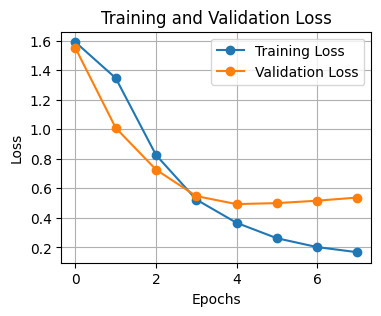

In [38]:
plt.figure(figsize=(4,3))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

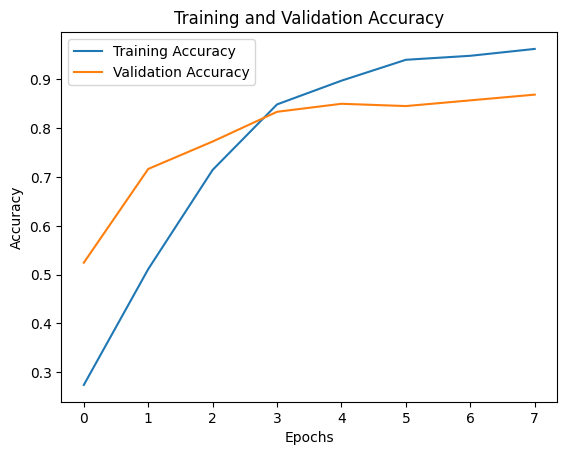

In [39]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


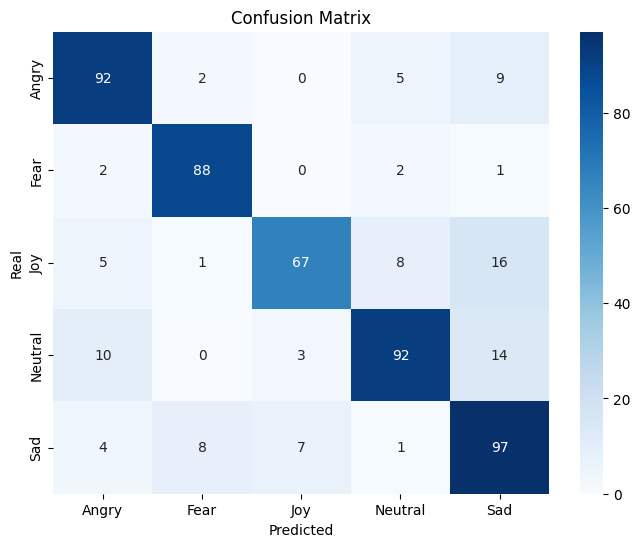

In [40]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

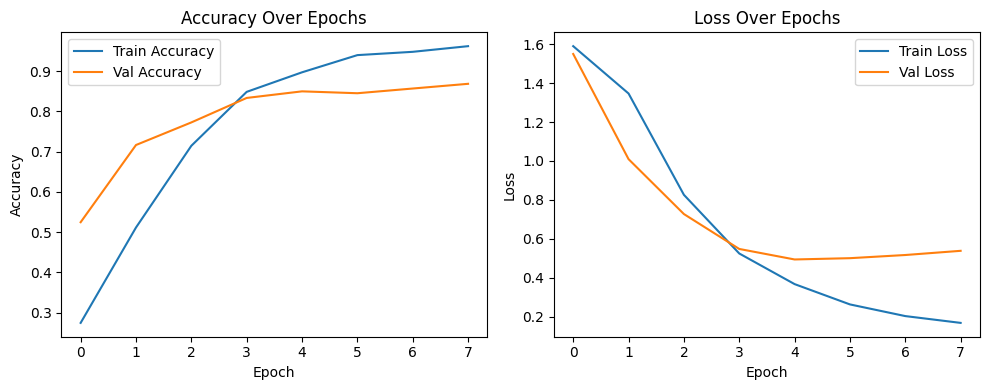

In [42]:
# LEARNING CURVES
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
new_sentences = [
    "I feel upset about the upcoming project",
    "This situation makes me anxious",
    "I went to library"
]

tokenizer = lambda x: [[word_to_index[word] for word in sentence.split() if word in word_to_index] for sentence in x]

new_sequences = tokenizer(new_sentences)
new_sequences_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post')

predictions = model.predict(new_sequences_padded)

predicted_emotions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

print("Predicted Emotions for New Sentences:")
for sentence, emotion in zip(new_sentences, predicted_emotions):
    print(f"Sentence: {sentence} | Predicted Emotion: {emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Emotions for New Sentences:
Sentence: I feel upset about the upcoming project | Predicted Emotion: Sad
Sentence: This situation makes me anxious | Predicted Emotion: Fear
Sentence: I went to library | Predicted Emotion: Neutral


In [46]:
import pickle

In [47]:
model.save('model.h5')

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved successfully!")


Model saved successfully!


In [48]:
# Save
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [49]:
from tensorflow.keras.models import load_model
import pickle

# Load the trained model
loaded_model = load_model("model.h5")

# Load the label encoder
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

In [50]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to preprocess new input (same as training preprocessing)
def preprocess_input(text, word_to_index, max_sequence_length):
    text = text.lower()                        # lowercase
    text = re.sub(r'\d+', '', text)            # remove numbers
    text = re.sub(r'http\S+|www\S+', '', text) # remove links
    text = re.sub(r'\s+', ' ', text).strip()   # remove extra spaces
    words = text.split()
    sequence = [word_to_index[word] for word in words if word in word_to_index]
    padded_sequence = pad_sequences([sequence], maxlen=max_sequence_length, padding='post')
    return padded_sequence

In [51]:
while True:
    user_input = input("\nType a sentence (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break

    # Preprocess input
    input_seq = preprocess_input(user_input, word_to_index, max_sequence_length)

    # Predict
    pred_prob = loaded_model.predict(input_seq)
    pred_label = label_encoder.inverse_transform([np.argmax(pred_prob)])

    print(f"Predicted Emotion: {pred_label[0]}")


Type a sentence (or 'quit' to exit): i got highest marks for exms
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
Predicted Emotion: Joy

Type a sentence (or 'quit' to exit): quit
